# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 10, 10, 10, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 10, 10, 10, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8797
Epoch 1/200, Iteration 2/12, Loss: 0.6649
Epoch 1/200, Iteration 3/12, Loss: 0.6976
Epoch 1/200, Iteration 4/12, Loss: 0.7074
Epoch 1/200, Iteration 5/12, Loss: 0.5562
Epoch 1/200, Iteration 6/12, Loss: 0.6856
Epoch 1/200, Iteration 7/12, Loss: 0.5567
Epoch 1/200, Iteration 8/12, Loss: 0.5122
Epoch 1/200, Iteration 9/12, Loss: 0.4995
Epoch 1/200, Iteration 10/12, Loss: 0.4627
Epoch 1/200, Iteration 11/12, Loss: 0.4517
Epoch 1/200, Iteration 12/12, Loss: 0.4705
Epoch 1/200, Iteration 13/12, Loss: 0.3945
Train Error: 
 Accuracy: 63.38%, Avg loss: 0.422731, MRE: 0.298051, MAE: 0.052006 

Test Error: 
 Accuracy: 63.0%, Avg loss: 0.446644, MRE: 0.271146, MAE: 0.057373 

Epoch 2/200, Iteration 1/12, Loss: 0.4011
Epoch 2/200, Iteration 2/12, Loss: 0.4031
Epoch 2/200, Iteration 3/12, Loss: 0.4260
Epoch 2/200, Iteration 4/12, Loss: 0.3784
Epoch 2/200, Iteration 5/12, Loss: 0.3447
Epoch 2/200, Iteration 6/12, Loss: 0.3056
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 92.75%, Avg loss: 0.071357, MRE: 0.059524, MAE: 0.009522 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.074035, MRE: 0.049679, MAE: 0.009758 

Epoch 13/200, Iteration 1/12, Loss: 0.0868
Epoch 13/200, Iteration 2/12, Loss: 0.0720
Epoch 13/200, Iteration 3/12, Loss: 0.0657
Epoch 13/200, Iteration 4/12, Loss: 0.0555
Epoch 13/200, Iteration 5/12, Loss: 0.0745
Epoch 13/200, Iteration 6/12, Loss: 0.0712
Epoch 13/200, Iteration 7/12, Loss: 0.0661
Epoch 13/200, Iteration 8/12, Loss: 0.0696
Epoch 13/200, Iteration 9/12, Loss: 0.0880
Epoch 13/200, Iteration 10/12, Loss: 0.0843
Epoch 13/200, Iteration 11/12, Loss: 0.0490
Epoch 13/200, Iteration 12/12, Loss: 0.0679
Epoch 13/200, Iteration 13/12, Loss: 0.0816
Train Error: 
 Accuracy: 88.62%, Avg loss: 0.070976, MRE: 0.057305, MAE: 0.009180 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.069964, MRE: 0.047331, MAE: 0.008876 

Epoch 14/200, Iteration 1/12, Loss: 0.0666
Epoch 14/200, Iteration 2/12, Loss: 0.0898
Epoch 14/200, Itera

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.073544, MRE: 0.053827, MAE: 0.009852 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.076786, MRE: 0.049515, MAE: 0.010144 

Epoch 25/200, Iteration 1/12, Loss: 0.0732
Epoch 25/200, Iteration 2/12, Loss: 0.0585
Epoch 25/200, Iteration 3/12, Loss: 0.0556
Epoch 25/200, Iteration 4/12, Loss: 0.0655
Epoch 25/200, Iteration 5/12, Loss: 0.0543
Epoch 25/200, Iteration 6/12, Loss: 0.0401
Epoch 25/200, Iteration 7/12, Loss: 0.0532
Epoch 25/200, Iteration 8/12, Loss: 0.0766
Epoch 25/200, Iteration 9/12, Loss: 0.0750
Epoch 25/200, Iteration 10/12, Loss: 0.0516
Epoch 25/200, Iteration 11/12, Loss: 0.0549
Epoch 25/200, Iteration 12/12, Loss: 0.0501
Epoch 25/200, Iteration 13/12, Loss: 0.0602
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.057751, MRE: 0.042194, MAE: 0.007033 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.056177, MRE: 0.034099, MAE: 0.006992 

Epoch 26/200, Iteration 1/12, Loss: 0.0567
Epoch 26/200, Iteration 2/12, Loss: 0.0539
Epoch 26/200, Itera

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.045432, MRE: 0.034206, MAE: 0.005614 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.045236, MRE: 0.030603, MAE: 0.005704 

Epoch 37/200, Iteration 1/12, Loss: 0.0378
Epoch 37/200, Iteration 2/12, Loss: 0.0422
Epoch 37/200, Iteration 3/12, Loss: 0.0499
Epoch 37/200, Iteration 4/12, Loss: 0.0693
Epoch 37/200, Iteration 5/12, Loss: 0.0376
Epoch 37/200, Iteration 6/12, Loss: 0.0547
Epoch 37/200, Iteration 7/12, Loss: 0.0324
Epoch 37/200, Iteration 8/12, Loss: 0.0492
Epoch 37/200, Iteration 9/12, Loss: 0.0416
Epoch 37/200, Iteration 10/12, Loss: 0.0326
Epoch 37/200, Iteration 11/12, Loss: 0.0572
Epoch 37/200, Iteration 12/12, Loss: 0.0389
Epoch 37/200, Iteration 13/12, Loss: 0.0510
Train Error: 
 Accuracy: 92.88%, Avg loss: 0.047551, MRE: 0.036267, MAE: 0.005811 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.042042, MRE: 0.030186, MAE: 0.005095 

Epoch 38/200, Iteration 1/12, Loss: 0.0425
Epoch 38/200, Iteration 2/12, Loss: 0.0664
Epoch 38/200, Iterat

Train Error: 
 Accuracy: 92.88%, Avg loss: 0.041983, MRE: 0.034059, MAE: 0.004772 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.036630, MRE: 0.026844, MAE: 0.004255 

Epoch 49/200, Iteration 1/12, Loss: 0.0429
Epoch 49/200, Iteration 2/12, Loss: 0.0437
Epoch 49/200, Iteration 3/12, Loss: 0.0599
Epoch 49/200, Iteration 4/12, Loss: 0.0559
Epoch 49/200, Iteration 5/12, Loss: 0.0521
Epoch 49/200, Iteration 6/12, Loss: 0.0399
Epoch 49/200, Iteration 7/12, Loss: 0.0378
Epoch 49/200, Iteration 8/12, Loss: 0.0497
Epoch 49/200, Iteration 9/12, Loss: 0.0487
Epoch 49/200, Iteration 10/12, Loss: 0.0367
Epoch 49/200, Iteration 11/12, Loss: 0.0504
Epoch 49/200, Iteration 12/12, Loss: 0.0493
Epoch 49/200, Iteration 13/12, Loss: 0.0533
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.044859, MRE: 0.036026, MAE: 0.005488 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.044362, MRE: 0.032208, MAE: 0.005523 

Epoch 50/200, Iteration 1/12, Loss: 0.0517
Epoch 50/200, Iteration 2/12, Loss: 0.0485
Epoch 50/200, Itera

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.042769, MRE: 0.034333, MAE: 0.005384 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036931, MRE: 0.026131, MAE: 0.004615 

Epoch 62/200, Iteration 1/12, Loss: 0.0509
Epoch 62/200, Iteration 2/12, Loss: 0.0373
Epoch 62/200, Iteration 3/12, Loss: 0.0370
Epoch 62/200, Iteration 4/12, Loss: 0.0391
Epoch 62/200, Iteration 5/12, Loss: 0.0321
Epoch 62/200, Iteration 6/12, Loss: 0.0301
Epoch 62/200, Iteration 7/12, Loss: 0.0258
Epoch 62/200, Iteration 8/12, Loss: 0.0299
Epoch 62/200, Iteration 9/12, Loss: 0.0359
Epoch 62/200, Iteration 10/12, Loss: 0.0319
Epoch 62/200, Iteration 11/12, Loss: 0.0270
Epoch 62/200, Iteration 12/12, Loss: 0.0236
Epoch 62/200, Iteration 13/12, Loss: 0.0290
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.027748, MRE: 0.022610, MAE: 0.003324 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.025909, MRE: 0.020025, MAE: 0.003240 

Epoch 63/200, Iteration 1/12, Loss: 0.0252
Epoch 63/200, Iteration 2/12, Loss: 0.0258
Epoch 63/200, Iter

Train Error: 
 Accuracy: 97.25%, Avg loss: 0.025532, MRE: 0.021499, MAE: 0.002986 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.023109, MRE: 0.019143, MAE: 0.002841 

Epoch 74/200, Iteration 1/12, Loss: 0.0253
Epoch 74/200, Iteration 2/12, Loss: 0.0251
Epoch 74/200, Iteration 3/12, Loss: 0.0279
Epoch 74/200, Iteration 4/12, Loss: 0.0195
Epoch 74/200, Iteration 5/12, Loss: 0.0207
Epoch 74/200, Iteration 6/12, Loss: 0.0260
Epoch 74/200, Iteration 7/12, Loss: 0.0254
Epoch 74/200, Iteration 8/12, Loss: 0.0202
Epoch 74/200, Iteration 9/12, Loss: 0.0279
Epoch 74/200, Iteration 10/12, Loss: 0.0283
Epoch 74/200, Iteration 11/12, Loss: 0.0259
Epoch 74/200, Iteration 12/12, Loss: 0.0300
Epoch 74/200, Iteration 13/12, Loss: 0.0322
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.025843, MRE: 0.021907, MAE: 0.003006 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.024587, MRE: 0.020106, MAE: 0.002969 

Epoch 75/200, Iteration 1/12, Loss: 0.0231
Epoch 75/200, Iteration 2/12, Loss: 0.0320
Epoch 75/200, Itera

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.024815, MRE: 0.020828, MAE: 0.002972 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022332, MRE: 0.018109, MAE: 0.002776 

Epoch 86/200, Iteration 1/12, Loss: 0.0207
Epoch 86/200, Iteration 2/12, Loss: 0.0187
Epoch 86/200, Iteration 3/12, Loss: 0.0306
Epoch 86/200, Iteration 4/12, Loss: 0.0300
Epoch 86/200, Iteration 5/12, Loss: 0.0249
Epoch 86/200, Iteration 6/12, Loss: 0.0216
Epoch 86/200, Iteration 7/12, Loss: 0.0265
Epoch 86/200, Iteration 8/12, Loss: 0.0256
Epoch 86/200, Iteration 9/12, Loss: 0.0189
Epoch 86/200, Iteration 10/12, Loss: 0.0237
Epoch 86/200, Iteration 11/12, Loss: 0.0252
Epoch 86/200, Iteration 12/12, Loss: 0.0262
Epoch 86/200, Iteration 13/12, Loss: 0.0261
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.024491, MRE: 0.020579, MAE: 0.002882 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.021962, MRE: 0.018131, MAE: 0.002699 

Epoch 87/200, Iteration 1/12, Loss: 0.0188
Epoch 87/200, Iteration 2/12, Loss: 0.0333
Epoch 87/200, Itera

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.023543, MRE: 0.020802, MAE: 0.002754 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020733, MRE: 0.017466, MAE: 0.002551 

Epoch 99/200, Iteration 1/12, Loss: 0.0324
Epoch 99/200, Iteration 2/12, Loss: 0.0191
Epoch 99/200, Iteration 3/12, Loss: 0.0263
Epoch 99/200, Iteration 4/12, Loss: 0.0226
Epoch 99/200, Iteration 5/12, Loss: 0.0203
Epoch 99/200, Iteration 6/12, Loss: 0.0282
Epoch 99/200, Iteration 7/12, Loss: 0.0211
Epoch 99/200, Iteration 8/12, Loss: 0.0300
Epoch 99/200, Iteration 9/12, Loss: 0.0214
Epoch 99/200, Iteration 10/12, Loss: 0.0210
Epoch 99/200, Iteration 11/12, Loss: 0.0253
Epoch 99/200, Iteration 12/12, Loss: 0.0223
Epoch 99/200, Iteration 13/12, Loss: 0.0139
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.022818, MRE: 0.019493, MAE: 0.002666 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.020169, MRE: 0.016981, MAE: 0.002475 

Epoch 100/200, Iteration 1/12, Loss: 0.0251
Epoch 100/200, Iteration 2/12, Loss: 0.0265
Epoch 100/200, Ite

Train Error: 
 Accuracy: 97.25%, Avg loss: 0.022699, MRE: 0.020220, MAE: 0.002677 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.020654, MRE: 0.017779, MAE: 0.002560 

Epoch 112/200, Iteration 1/12, Loss: 0.0204
Epoch 112/200, Iteration 2/12, Loss: 0.0282
Epoch 112/200, Iteration 3/12, Loss: 0.0238
Epoch 112/200, Iteration 4/12, Loss: 0.0186
Epoch 112/200, Iteration 5/12, Loss: 0.0190
Epoch 112/200, Iteration 6/12, Loss: 0.0249
Epoch 112/200, Iteration 7/12, Loss: 0.0250
Epoch 112/200, Iteration 8/12, Loss: 0.0191
Epoch 112/200, Iteration 9/12, Loss: 0.0219
Epoch 112/200, Iteration 10/12, Loss: 0.0271
Epoch 112/200, Iteration 11/12, Loss: 0.0213
Epoch 112/200, Iteration 12/12, Loss: 0.0278
Epoch 112/200, Iteration 13/12, Loss: 0.0213
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.022674, MRE: 0.019766, MAE: 0.002713 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.019186, MRE: 0.016616, MAE: 0.002397 

Epoch 113/200, Iteration 1/12, Loss: 0.0185
Epoch 113/200, Iteration 2/12, Loss: 0.0266
Epoch

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.021863, MRE: 0.019004, MAE: 0.002591 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018861, MRE: 0.016174, MAE: 0.002338 

Epoch 124/200, Iteration 1/12, Loss: 0.0191
Epoch 124/200, Iteration 2/12, Loss: 0.0159
Epoch 124/200, Iteration 3/12, Loss: 0.0244
Epoch 124/200, Iteration 4/12, Loss: 0.0282
Epoch 124/200, Iteration 5/12, Loss: 0.0188
Epoch 124/200, Iteration 6/12, Loss: 0.0150
Epoch 124/200, Iteration 7/12, Loss: 0.0267
Epoch 124/200, Iteration 8/12, Loss: 0.0201
Epoch 124/200, Iteration 9/12, Loss: 0.0240
Epoch 124/200, Iteration 10/12, Loss: 0.0285
Epoch 124/200, Iteration 11/12, Loss: 0.0185
Epoch 124/200, Iteration 12/12, Loss: 0.0233
Epoch 124/200, Iteration 13/12, Loss: 0.0217
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.021002, MRE: 0.018821, MAE: 0.002466 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017981, MRE: 0.015946, MAE: 0.002227 

Epoch 125/200, Iteration 1/12, Loss: 0.0160
Epoch 125/200, Iteration 2/12, Loss: 0.0121
Epoc

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.021537, MRE: 0.019226, MAE: 0.002529 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.017810, MRE: 0.016060, MAE: 0.002198 

Epoch 136/200, Iteration 1/12, Loss: 0.0178
Epoch 136/200, Iteration 2/12, Loss: 0.0203
Epoch 136/200, Iteration 3/12, Loss: 0.0353
Epoch 136/200, Iteration 4/12, Loss: 0.0226
Epoch 136/200, Iteration 5/12, Loss: 0.0204
Epoch 136/200, Iteration 6/12, Loss: 0.0172
Epoch 136/200, Iteration 7/12, Loss: 0.0197
Epoch 136/200, Iteration 8/12, Loss: 0.0159
Epoch 136/200, Iteration 9/12, Loss: 0.0169
Epoch 136/200, Iteration 10/12, Loss: 0.0189
Epoch 136/200, Iteration 11/12, Loss: 0.0331
Epoch 136/200, Iteration 12/12, Loss: 0.0150
Epoch 136/200, Iteration 13/12, Loss: 0.0186
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.021203, MRE: 0.019029, MAE: 0.002470 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016998, MRE: 0.015413, MAE: 0.002107 

Epoch 137/200, Iteration 1/12, Loss: 0.0266
Epoch 137/200, Iteration 2/12, Loss: 0.0174
Epoch

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.020094, MRE: 0.018364, MAE: 0.002362 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016428, MRE: 0.015030, MAE: 0.002041 

Epoch 148/200, Iteration 1/12, Loss: 0.0227
Epoch 148/200, Iteration 2/12, Loss: 0.0193
Epoch 148/200, Iteration 3/12, Loss: 0.0280
Epoch 148/200, Iteration 4/12, Loss: 0.0206
Epoch 148/200, Iteration 5/12, Loss: 0.0247
Epoch 148/200, Iteration 6/12, Loss: 0.0169
Epoch 148/200, Iteration 7/12, Loss: 0.0139
Epoch 148/200, Iteration 8/12, Loss: 0.0196
Epoch 148/200, Iteration 9/12, Loss: 0.0181
Epoch 148/200, Iteration 10/12, Loss: 0.0149
Epoch 148/200, Iteration 11/12, Loss: 0.0191
Epoch 148/200, Iteration 12/12, Loss: 0.0223
Epoch 148/200, Iteration 13/12, Loss: 0.0188
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019596, MRE: 0.017903, MAE: 0.002304 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016513, MRE: 0.015068, MAE: 0.002047 

Epoch 149/200, Iteration 1/12, Loss: 0.0184
Epoch 149/200, Iteration 2/12, Loss: 0.0214
Epoch

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019694, MRE: 0.018099, MAE: 0.002311 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016265, MRE: 0.014923, MAE: 0.002023 

Epoch 160/200, Iteration 1/12, Loss: 0.0165
Epoch 160/200, Iteration 2/12, Loss: 0.0219
Epoch 160/200, Iteration 3/12, Loss: 0.0141
Epoch 160/200, Iteration 4/12, Loss: 0.0170
Epoch 160/200, Iteration 5/12, Loss: 0.0228
Epoch 160/200, Iteration 6/12, Loss: 0.0276
Epoch 160/200, Iteration 7/12, Loss: 0.0136
Epoch 160/200, Iteration 8/12, Loss: 0.0194
Epoch 160/200, Iteration 9/12, Loss: 0.0173
Epoch 160/200, Iteration 10/12, Loss: 0.0340
Epoch 160/200, Iteration 11/12, Loss: 0.0151
Epoch 160/200, Iteration 12/12, Loss: 0.0165
Epoch 160/200, Iteration 13/12, Loss: 0.0241
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019568, MRE: 0.017976, MAE: 0.002303 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016408, MRE: 0.014985, MAE: 0.002045 

Epoch 161/200, Iteration 1/12, Loss: 0.0173
Epoch 161/200, Iteration 2/12, Loss: 0.0231
Epoch 

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.020302, MRE: 0.018784, MAE: 0.002371 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016284, MRE: 0.014912, MAE: 0.002022 

Epoch 173/200, Iteration 1/12, Loss: 0.0152
Epoch 173/200, Iteration 2/12, Loss: 0.0229
Epoch 173/200, Iteration 3/12, Loss: 0.0156
Epoch 173/200, Iteration 4/12, Loss: 0.0144
Epoch 173/200, Iteration 5/12, Loss: 0.0159
Epoch 173/200, Iteration 6/12, Loss: 0.0286
Epoch 173/200, Iteration 7/12, Loss: 0.0232
Epoch 173/200, Iteration 8/12, Loss: 0.0203
Epoch 173/200, Iteration 9/12, Loss: 0.0202
Epoch 173/200, Iteration 10/12, Loss: 0.0138
Epoch 173/200, Iteration 11/12, Loss: 0.0213
Epoch 173/200, Iteration 12/12, Loss: 0.0270
Epoch 173/200, Iteration 13/12, Loss: 0.0183
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.019612, MRE: 0.018014, MAE: 0.002310 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016512, MRE: 0.015145, MAE: 0.002045 

Epoch 174/200, Iteration 1/12, Loss: 0.0154
Epoch 174/200, Iteration 2/12, Loss: 0.0143
Epoch

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.019537, MRE: 0.020017, MAE: 0.002311 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016128, MRE: 0.014875, MAE: 0.002003 

Epoch 185/200, Iteration 1/12, Loss: 0.0166
Epoch 185/200, Iteration 2/12, Loss: 0.0149
Epoch 185/200, Iteration 3/12, Loss: 0.0182
Epoch 185/200, Iteration 4/12, Loss: 0.0205
Epoch 185/200, Iteration 5/12, Loss: 0.0298
Epoch 185/200, Iteration 6/12, Loss: 0.0180
Epoch 185/200, Iteration 7/12, Loss: 0.0189
Epoch 185/200, Iteration 8/12, Loss: 0.0161
Epoch 185/200, Iteration 9/12, Loss: 0.0255
Epoch 185/200, Iteration 10/12, Loss: 0.0247
Epoch 185/200, Iteration 11/12, Loss: 0.0190
Epoch 185/200, Iteration 12/12, Loss: 0.0181
Epoch 185/200, Iteration 13/12, Loss: 0.0113
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019405, MRE: 0.018080, MAE: 0.002288 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016095, MRE: 0.014902, MAE: 0.001996 

Epoch 186/200, Iteration 1/12, Loss: 0.0211
Epoch 186/200, Iteration 2/12, Loss: 0.0189
Epoch

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019557, MRE: 0.018182, MAE: 0.002298 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016079, MRE: 0.014853, MAE: 0.001997 

Epoch 197/200, Iteration 1/12, Loss: 0.0176
Epoch 197/200, Iteration 2/12, Loss: 0.0153
Epoch 197/200, Iteration 3/12, Loss: 0.0255
Epoch 197/200, Iteration 4/12, Loss: 0.0174
Epoch 197/200, Iteration 5/12, Loss: 0.0189
Epoch 197/200, Iteration 6/12, Loss: 0.0245
Epoch 197/200, Iteration 7/12, Loss: 0.0188
Epoch 197/200, Iteration 8/12, Loss: 0.0197
Epoch 197/200, Iteration 9/12, Loss: 0.0228
Epoch 197/200, Iteration 10/12, Loss: 0.0156
Epoch 197/200, Iteration 11/12, Loss: 0.0150
Epoch 197/200, Iteration 12/12, Loss: 0.0232
Epoch 197/200, Iteration 13/12, Loss: 0.0198
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.019690, MRE: 0.018080, MAE: 0.002304 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016115, MRE: 0.014879, MAE: 0.002002 

Epoch 198/200, Iteration 1/12, Loss: 0.0221
Epoch 198/200, Iteration 2/12, Loss: 0.0193
Epoch 

#### Plots loss vs Epoch

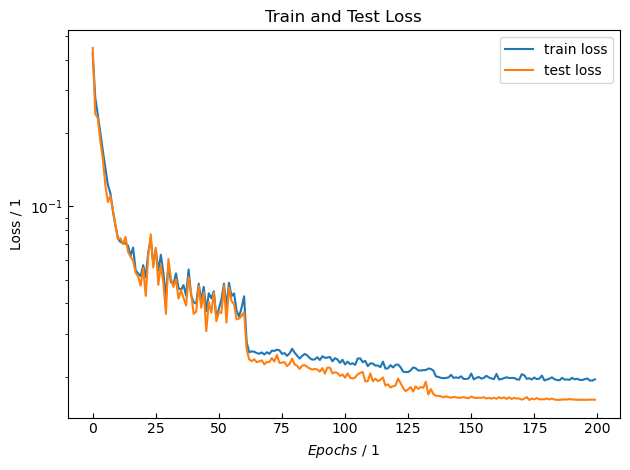

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Speichern der Trainingskurve

In [11]:
np.savez('data/models/hyperparams/loss_005_006.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9995541844271926 , R^2(NH3) = 0.9952048361189797
Test Dataset: R^2(H2) = 0.9994720187950055 , R^2(NH3) = 0.9990870596199933
Max Error Training: |x_H2 - x_H2,pred| = 0.05501394898545481 , |x_NH3 - x_NH3,pred| = 0.06833408537733973
Max Error Test: |x_H2 - x_H2,pred| = 0.019567835420953694 , |x_NH3 - x_NH3,pred| = 0.011012685930576319


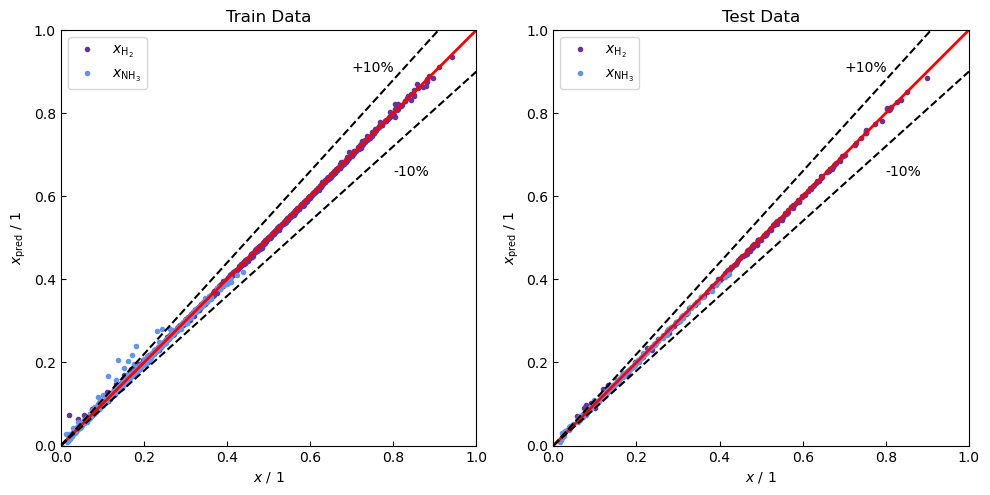

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

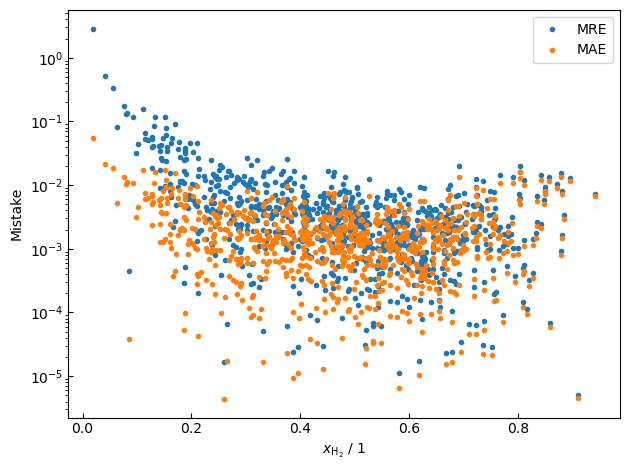

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

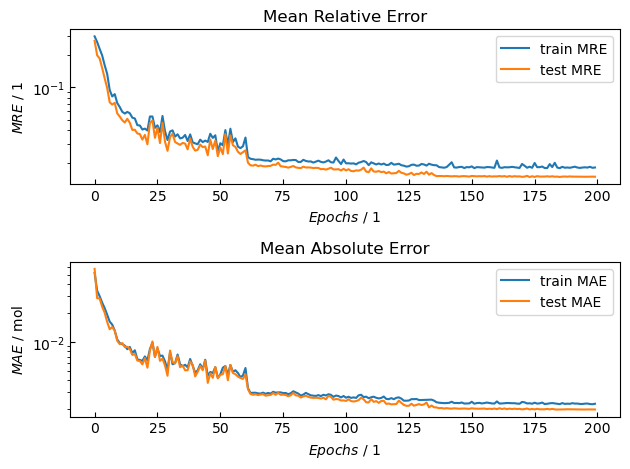

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

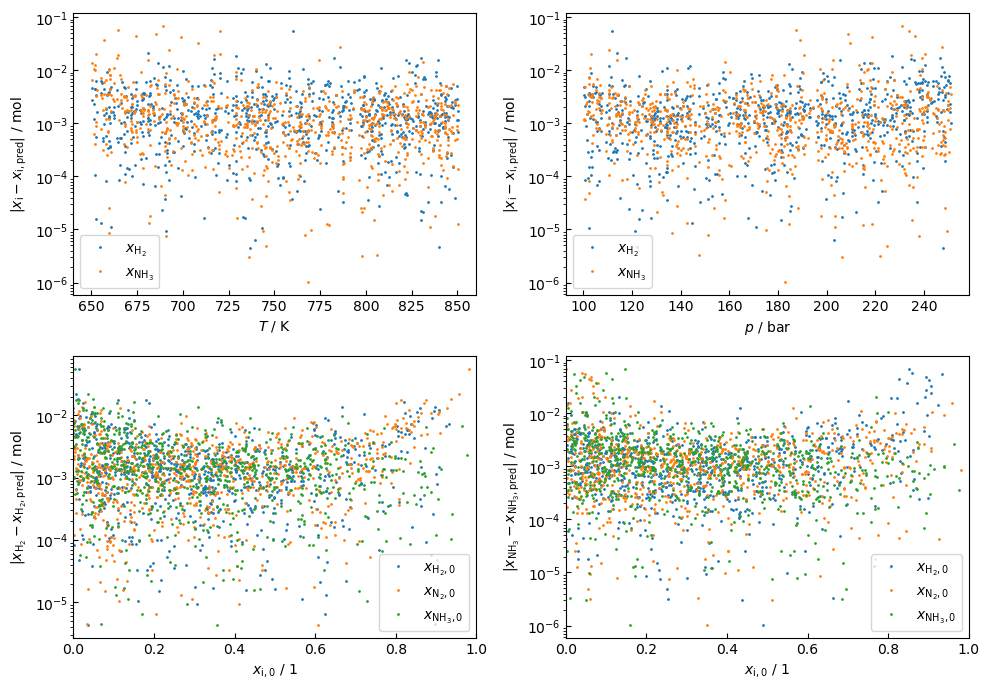

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

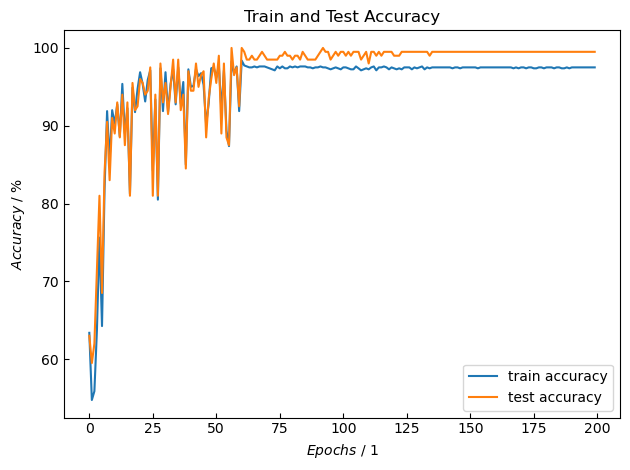

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.2071, -1.0022, -1.1003, -1.0869,  2.1908],
        [-0.2569,  1.4539,  2.1698, -1.2085, -0.8942],
        [ 1.1188, -0.3416,  0.3875, -1.1822,  0.8280],
        [-0.4212,  0.1553, -1.1526, -1.1303,  2.2864],
        [ 1.0805,  1.4381, -0.3820,  0.6188, -0.2576],
        [-1.4028, -0.7505,  1.4111, -0.6276, -0.7434],
        [ 0.2214,  0.9939, -1.0644,  2.1124, -1.1144],
        [ 1.3896, -1.0719, -0.6107,  0.2069,  0.3879],
        [-1.3038, -1.5498, -1.2927, -0.6445,  1.9273],
        [ 1.3365,  0.8808, -0.9499, -0.3153,  1.2544],
        [ 0.3287, -0.0761, -1.0797, -0.1199,  1.1822],
        [ 1.4271, -1.3029,  0.9939, -1.1879,  0.2387],
        [-0.6080,  0.7185,  0.0349,  1.1513, -1.2110],
        [ 1.1288,  1.0831, -0.2996, -0.3538,  0.6557],
        [-1.3906, -0.5390,  0.4793, -0.4486, -0.0119],
        [-0.0088, -0.0926, -1.1977,  1.3595, -0.2142],
        [ 1.3474,  1.6291, -0.3303, -1.1168,  1.4656],
        [-1.6168, -1.5985,  0.0319,  1.2617, -1.3209],
        [ 

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.1210,  0.1821,  0.1149, -0.2483, -0.1000],
         [-0.1739,  0.0635,  0.5264, -0.0488,  0.2424],
         [ 0.2933, -0.2324,  0.1885, -0.3513,  0.0574],
         [-0.3560,  0.3115,  0.2411, -0.2456,  0.0676],
         [-0.0885, -0.0200, -0.4120,  0.4245, -0.2610],
         [-0.3587,  0.0524, -0.0560,  0.0501,  0.1331],
         [-0.0599, -0.1125, -0.0349, -0.3706, -0.0176],
         [-0.1628, -0.2273,  0.0956, -0.1314,  0.0428],
         [ 0.0299,  0.0028, -0.0685,  0.3792, -0.2420],
         [-0.1279, -0.2580, -0.0528,  0.2491, -0.0533]], requires_grad=True),
 Parameter containing:
 tensor([-0.4878, -0.4734, -0.0912,  0.1127,  0.4409, -0.4836,  0.0124, -0.0507,
         -0.8891, -0.5957], requires_grad=True),
 Parameter containing:
 tensor([[-2.0131e-01, -1.1311e+00,  4.0164e-01, -1.8562e-01, -8.1115e-02,
          -5.7233e-01,  1.3807e-01, -2.2239e-01, -3.1883e-02, -2.4635e-01],
         [ 8.0869e-01,  8.8114e-01,  2.5283e-01, -6.0861e-01, -4.902

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4003, 0.7167, 0.5177, 0.9283, 0.8382],
        [0.9513, 0.4527, 0.5630, 0.1525, 0.3743]])
tensor([[-0.3041,  0.4913],
        [ 0.3821, -0.1906]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.6303, -0.8962, -0.5810,  1.2246, -0.6814],
        [-0.3817,  0.7029, -0.1395,  1.0865, -0.9736],
        [ 1.1170,  0.1261,  1.8675, -1.1061, -0.7023],
        [ 0.9944,  1.4025,  1.3257, -0.7635, -0.5206],
        [ 1.0444,  0.0678,  0.5252,  0.0972, -0.6148],
        [-0.1166,  0.2879,  0.7154, -0.6770, -0.0101],
        [-0.4273, -0.8775,  0.7844, -0.2223, -0.5426],
        [ 0.4220,  0.8991,  0.1320, -0.2456,  0.1215],
        [ 1.2310, -0.7250, -0.8554,  2.0696, -1.2758],
        [-1.7687, -1.2105, -1.1468,  1.3729, -0.2778],
        [-0.8798, -0.6236,  1.1565, -0.4773, -0.6471],
        [-0.7087,  0.6343, -1.2216,  0.5533,  0.6333],
        [ 1.3474,  1.6291, -0.3303, -1.1168,  1.4656],
        [-1.4110, -0.2312, -0.6587,  0.4828,  0.1530],
        [ 0.8075,  0.8243,  0.4517, -0.9248,  0.5020],
        [ 0.1229,  1.0749, -0.4360,  1.6668, -1.2758],
        [-0.7997, -1.0352, -0.2507, -0.1386,  0.3877],
        [ 1.3365,  0.8808, -0.9499, -0.3153,  1.2544],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()